# EEG Conformer (No Preprocessing) with SMOTE Balancing
This notebook is a copy of the undersampling version, but uses **SMOTE** to oversample the minority class instead of random undersampling.

In [1]:
import numpy as np
import h5py
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
X_all = []
y_all = []

ch_ch = list(range(63))
g_ch = list(range(61))
ch_rem = [0, 2, 6, 8, 29, 31, 51, 55]
g_rem = [46, 49, 56, 58, 59, 60]

In [3]:
for i in ch_rem:
    ch_ch.remove(i)
for j in g_rem:
    g_ch.remove(j)

print("Chinese load")
for subj in range(1, 10):
    file_path = f'C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_{subj}.mat'
    try:
        print(f"Loading file: {file_path}")
        mat_data = loadmat(file_path)
        X = np.array(mat_data['x_post'])[:-1, ch_ch, :]
        y = np.array(mat_data['label_next_ind'])[0, :]
        X = np.transpose(X)
        X_all.append(X)
        y_all.append(y)
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

print("Korean load")
for subj in range(1, 15):
    file_path = f'C:/Users/USER/Desktop/RA/data/ASK/sbj_{subj}.mat'
    try:
        with h5py.File(file_path, 'r') as f:
            print(f"Loading file: {file_path}")
            X = np.array(f['x_post'])[:, g_ch, :]
            y = np.array(f['label_next_ind'])[:, 0]
        X_all.append(X)
        y_all.append(y)
    except OSError as e:
        print(f"Error loading file {file_path}: {e}")

Chinese load
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_1.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_2.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_3.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_2.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_3.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_4.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_5.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_4.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_5.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_6.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_7.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_6.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_7.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_8.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_8.mat
Loading file: C:/Users/USER/Desktop/RA/data_ch/ASK/sbj_9.mat
Loading fil

In [4]:
data = np.concatenate(X_all, axis=0)
labels = np.concatenate(y_all, axis=0)

print("Shape of data before flattening:", data.shape)
data_flattened = data.reshape(data.shape[0], -1)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_flattened)
data_normalized = data_normalized.reshape(data.shape)
print("Shape of normalized data:", data_normalized.shape)

# Balance the dataset using SMOTE (oversampling)
smote = SMOTE(random_state=42)
data_resampled, labels_resampled = smote.fit_resample(data_normalized.reshape(data_normalized.shape[0], -1), labels)
data_resampled = data_resampled.reshape(-1, data.shape[1], data.shape[2])

print("Original label distribution:", np.bincount(labels.astype(int)))
print("Resampled label distribution:", np.bincount(labels_resampled.astype(int)))
print("Shape after SMOTE:", data_resampled.shape)

# Split the balanced dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data_resampled, labels_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Shape of data before flattening: (50440, 55, 100)
Shape of normalized data: (50440, 55, 100)
Shape of normalized data: (50440, 55, 100)
Original label distribution: [32197 18243]
Resampled label distribution: [32197 32197]
Shape after SMOTE: (64394, 55, 100)
Original label distribution: [32197 18243]
Resampled label distribution: [32197 32197]
Shape after SMOTE: (64394, 55, 100)
Training set shape: (45075, 55, 100)
Validation set shape: (9659, 55, 100)
Testing set shape: (9660, 55, 100)
Training set shape: (45075, 55, 100)
Validation set shape: (9659, 55, 100)
Testing set shape: (9660, 55, 100)


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from Conformer.conformer.conformer import Conformer
from torch.optim.lr_scheduler import ReduceLROnPlateau
num_epochs = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Conformer(emb_size=40, depth=6, n_classes=2).to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

# Tensors (do this ONCE!)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device) 
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)

for X_batch, y_batch in train_loader:
    print(X_batch.shape)
    break

best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        _, logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            _, val_logits = model(X_batch)
            val_loss += criterion(val_logits, y_batch).item()
            preds = val_logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    scheduler.step(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_conformer_smote.pt")
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

torch.Size([32, 1, 55, 100])
Epoch 1 | Train Loss: 0.7217 | Val Loss: 0.6961 | Val Acc: 0.5044
Epoch 1 | Train Loss: 0.7217 | Val Loss: 0.6961 | Val Acc: 0.5044
Epoch 2 | Train Loss: 0.7128 | Val Loss: 0.6923 | Val Acc: 0.5257
Epoch 2 | Train Loss: 0.7128 | Val Loss: 0.6923 | Val Acc: 0.5257
Epoch 3 | Train Loss: 0.7093 | Val Loss: 0.6932 | Val Acc: 0.5156
Epoch 3 | Train Loss: 0.7093 | Val Loss: 0.6932 | Val Acc: 0.5156
Epoch 4 | Train Loss: 0.7056 | Val Loss: 0.6922 | Val Acc: 0.5044
Epoch 4 | Train Loss: 0.7056 | Val Loss: 0.6922 | Val Acc: 0.5044
Epoch 5 | Train Loss: 0.7038 | Val Loss: 0.6919 | Val Acc: 0.5032
Epoch 5 | Train Loss: 0.7038 | Val Loss: 0.6919 | Val Acc: 0.5032
Epoch 6 | Train Loss: 0.7032 | Val Loss: 0.6919 | Val Acc: 0.5144
Epoch 6 | Train Loss: 0.7032 | Val Loss: 0.6919 | Val Acc: 0.5144
Epoch 7 | Train Loss: 0.6997 | Val Loss: 0.6914 | Val Acc: 0.5142
Epoch 7 | Train Loss: 0.6997 | Val Loss: 0.6914 | Val Acc: 0.5142
Epoch 8 | Train Loss: 0.6979 | Val Loss: 0.6922

Missing keys: []
Unexpected keys: ['2.fc.0.weight', '2.fc.0.bias', '2.fc.3.weight', '2.fc.3.bias', '2.fc.6.weight', '2.fc.6.bias']
Accuracy on test set: 0.5037267080745341
Accuracy on test set: 0.5037267080745341


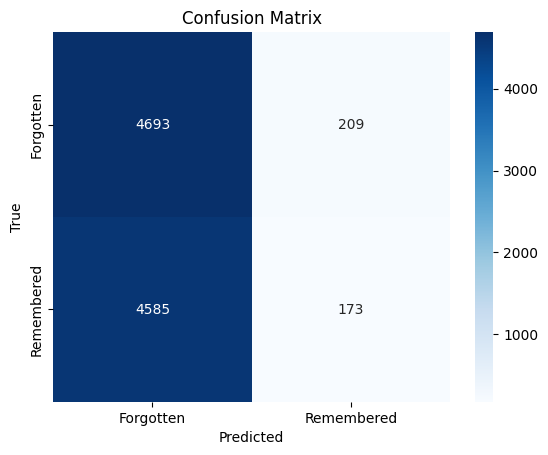

              precision    recall  f1-score   support

   Forgotten       0.51      0.96      0.66      4902
  Remembered       0.45      0.04      0.07      4758

    accuracy                           0.50      9660
   macro avg       0.48      0.50      0.36      9660
weighted avg       0.48      0.50      0.37      9660



In [6]:
from Conformer.conformer.conformer import Conformer
from sklearn.metrics import accuracy_score
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

model = Conformer(emb_size=40, depth=6, n_classes=2).to(device)
state_dict = torch.load("best_conformer_smote.pt", map_location=device)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
model.eval()

batch_size = 64
predictions = []

with torch.no_grad():
    for i in range(0, X_test_tensor.shape[0], batch_size):
        X_batch = X_test_tensor[i:i+batch_size]
        _, logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        predictions.append(preds.cpu().numpy())

y_pred_labels = np.concatenate(predictions)
y_true_labels = y_test.astype(int)
test_acc = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy on test set:", test_acc )
# --- Confusion Matrix ---
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Forgotten', 'Remembered'],
            yticklabels=['Forgotten', 'Remembered'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# --- Classification Report ---
print(classification_report(y_true_labels, y_pred_labels, target_names=['Forgotten', 'Remembered']))